In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute
X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))
print(X_motion.shape)
print(Y_motion.shape)

(6143, 28)
(6143, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FL/RR are swinging
idxs = np.where(X_motion[:, 24] == 1)[0]
X_motion_RR_swinging = X_motion[idxs]
Y_motion_RR_swinging = Y_motion[idxs]

## Predict RR foot -> x

In [8]:
X_motion_RR_swinging[0, :]

array([ 0.1       ,  0.        ,  0.        ,  0.04429445, -0.0763995 ,
        0.02945058, -0.0146854 ,  0.00673978,  0.01790485,  0.22657506,
        0.18870623, -0.4303382 ,  0.24251341, -0.17037205, -0.43098021,
       -0.23804776,  0.16513788, -0.42953227, -0.2633686 , -0.13826779,
       -0.43035149,  1.        ,  0.        ,  0.        ,  1.        ,
        0.1       ,  0.        ,  0.        ])

In [9]:
Y_motion_RR_swinging[0, :]

array([ 0.01997748, -0.00154138,  0.02591898, -0.00928865])

### Linear Regression

In [11]:
# Input
X = np.hstack((X_motion_RR_swinging[:, :3], # prev velocity command
               X_motion_RR_swinging[:, -3:], # commanded velocity command
               X_motion_RR_swinging[:, 9:11], # FL (x,y) position
               X_motion_RR_swinging[:, 12:14], # FR (x,y) position
               X_motion_RR_swinging[:, 15:17], # RL (x,y) position
               X_motion_RR_swinging[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_motion_RR_swinging[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rr_relative_swinging_x = LinearRegression()

# Fit the model
model_rr_relative_swinging_x.fit(X_train, Y_train)

# Predict
predictions = model_rr_relative_swinging_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9958674632588641
RMSE:  0.002430474632862701
The lowest error is:  3.3763703067568596e-06
The highest error is:  0.020569225287060566
The avg. error is:  0.0012366561416225544


In [12]:
model_rr_relative_swinging_x.coef_

array([[-2.39600967e-03,  0.00000000e+00, -8.32667268e-17,
         2.13808033e-01, -8.32667268e-17, -5.55111512e-17,
         2.78825266e-01,  3.78073944e-01,  9.98187558e-02,
        -2.16376607e-01,  9.44990214e-02, -8.58580716e-02,
        -5.95677198e-01, -3.84988182e-01]])

In [13]:
model_rr_relative_swinging_x.intercept_

array([-0.36804565])

Text(0, 0.5, 'Predictions')

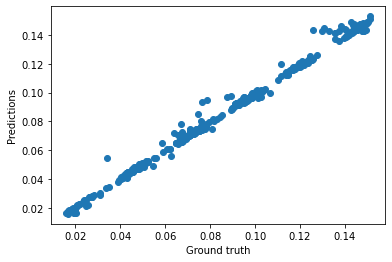

In [14]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [15]:
#%store model_rr_relative_swinging_x

In [16]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [17]:
# Save model
#joblib.dump(model_rr_relative_swinging_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rr_relative_swinging_x.sav")

### Predict RR foot -> y

In [18]:
# Input
X = np.hstack((X_motion_RR_swinging[:, :3], # prev velocity command
               X_motion_RR_swinging[:, -3:], # commanded velocity command
               X_motion_RR_swinging[:, 9:11], # FL (x,y) position
               X_motion_RR_swinging[:, 12:14], # FR (x,y) position
               X_motion_RR_swinging[:, 15:17], # RL (x,y) position
               X_motion_RR_swinging[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_motion_RR_swinging[:, 3]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rr_relative_swinging_y = LinearRegression()

# Fit the model
model_rr_relative_swinging_y.fit(X_train, Y_train)

# Predict
predictions = model_rr_relative_swinging_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.7500078631471774
RMSE:  0.0016645727946717516
The lowest error is:  1.317741802120409e-06
The highest error is:  0.015315837411316924
The avg. error is:  0.0008425989362162037


In [19]:
model_rr_relative_swinging_y.coef_

array([[ 5.24114429e-03, -5.55111512e-17,  0.00000000e+00,
         2.34891875e-02, -1.11022302e-16, -5.55111512e-17,
         2.60329861e-01,  5.28907677e-01, -1.00852317e-01,
         1.43110999e-01, -6.79526783e-02, -4.05586383e-02,
        -1.34780052e-01, -7.57837470e-01]])

In [20]:
model_rr_relative_swinging_y.intercept_

array([-0.27440417])

Text(0, 0.5, 'Predictions')

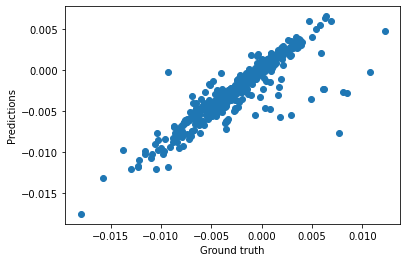

In [21]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [38]:
#%store model_rr_relative_swinging_y

In [30]:
#for idx, prediction in enumerate(predictions):
#    print(f'Input: {X_test[idx]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [31]:
# Save model
#joblib.dump(model_rr_relative_swinging_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rr_relative_swinging_y.sav")